In [1]:
%%writefile requirements.txt

ipywidgets
matplotlib
ujson
pathlib
#mxnet
mxnet-cu112
gluonts

Overwriting requirements.txt


In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install mxnet-cu112
#!pip uninstall mxnet-cu112 -y

  Using cached mxnet_cu112-1.9.0-py3-none-manylinux2014_x86_64.whl (497.6 MB)


In [4]:
import IPython

## Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import mxnet

In [3]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta
from pathlib import Path

In [4]:
from mxnet import gpu

In [5]:
from gluonts.dataset.util import to_pandas
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation import Evaluator
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.mx.distribution import NegativeBinomialOutput
from gluonts.evaluation import make_evaluation_predictions

In [6]:
mx.context.num_gpus()

1

## Loading Data

In [7]:
daily_data_dir = Path('./data')

In [8]:
nbcu_comp_train = pd.read_csv(daily_data_dir/"nbcu_ad_req_10yr_train.csv", index_col=1, parse_dates=True, header=None)
nbcu_comp_train.columns = ['site_id', 'inventory']
nbcu_comp_test = pd.read_csv(daily_data_dir/"nbcu_ad_req_10yr_test.csv", index_col=1, parse_dates=True, header=None)
nbcu_comp_test.columns = ['site_id', 'inventory']
event_ts = pd.read_csv(daily_data_dir/"event_ts_2021-12-05.csv", index_col=1, parse_dates=True, header=None)
event_ts.columns = ['site_id', 'nfl', 'so', 'wo']

In [9]:
print('Train:', nbcu_comp_train.shape)
print('Test:', nbcu_comp_test.shape)
print('Event:', event_ts.shape)

Train: (3647, 2)
Test: (41, 2)
Event: (3688, 4)


In [11]:
ds_meta = {
    'num_series': 1,
    'num_steps': nbcu_comp_train.shape[0],
    'prediction_length': nbcu_comp_test.shape[0],
    'validation_length': nbcu_comp_test.shape[0],
    'freq': '1D',
    'start': [
        nbcu_comp_train.index[0]
        for _ in range(1)
    ]
}

In [12]:
merged_df = pd.concat(
    [nbcu_comp_train, nbcu_comp_test], axis=0
)

## Plot and data-set func

In [13]:
def plot_prob_forecasts(ts_entry, forecast_entry, plot_length=150, prediction_intervals = (10.0, 90.0)):
    
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [14]:
def network_dataset(data_df:pd, event, freq='D', valid_length=0, test_length=0):
    # data_df: base dataset from by network inventories
    data_df = data_df.pivot_table(index=data_df.index, columns=['site_id']).fillna(0)
    
    #remove this line after testing
    #data_df = data_df[1:2]
    
    num_series, num_steps = data_df.shape
    print(num_series, num_steps, data_df.columns[0][1]) 
    
    train_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r[:-(valid_length+test_length)],
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event[:-(valid_length+test_length)].transpose(),
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )
    valid_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r[:-test_length],
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event[:-test_length].transpose(),
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )    
    test_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r,
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event.transpose(),
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )
    
    return train_ds, valid_ds, test_ds #target, feat_dynamic_real, feat_static_cat

## Data set prep and review

In [15]:
train_ds, valid_ds, test_ds = network_dataset(
    merged_df, 
    event_ts[['nfl', 'so', 'wo']].values,
    freq=ds_meta['freq'],
    valid_length=ds_meta['validation_length'],
    test_length=ds_meta['prediction_length']
)

1 3688 2011-11-01 00:00:00


In [16]:
train_entry = next(iter(train_ds))
train_entry.keys()
valid_entry = next(iter(valid_ds))
valid_entry.keys()
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['item_id', 'target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

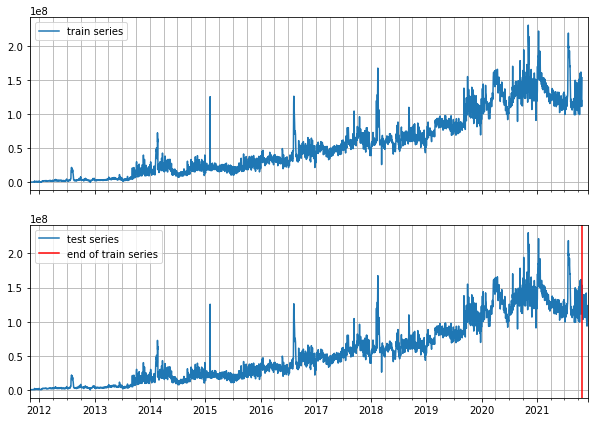

In [18]:
test_series = to_pandas(test_entry)
valid_series = to_pandas(valid_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

valid_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(valid_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Training

In [21]:
deepAR_estimator = DeepAREstimator(
    prediction_length=ds_meta['prediction_length'],
    context_length=3*ds_meta['prediction_length'],
    freq=ds_meta['freq'],
    num_layers=5,
    num_cells=90,
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=True,
    use_feat_static_cat=False,
#    cardinality=stat_cat_cardinalities,
    dropout_rate=0.1,
    cell_type='lstm',
    trainer=Trainer(   
        ctx=gpu(0),
        learning_rate=1e-3,
        epochs=60,
        num_batches_per_epoch=90,
        batch_size=128
    )
)

### with event

In [22]:
deepAR_predictor = deepAR_estimator.train(training_data=train_ds, validation_data=valid_ds)

100%|██████████| 90/90 [00:37<00:00,  2.43it/s, epoch=1/60, avg_epoch_loss=7.01]
1it [00:00,  1.84it/s, epoch=1/60, validation_avg_epoch_loss=0.977]
100%|██████████| 90/90 [00:35<00:00,  2.54it/s, epoch=2/60, avg_epoch_loss=6.68]
1it [00:00,  1.83it/s, epoch=2/60, validation_avg_epoch_loss=0.833]
100%|██████████| 90/90 [00:34<00:00,  2.58it/s, epoch=3/60, avg_epoch_loss=6.2] 
1it [00:00,  1.74it/s, epoch=3/60, validation_avg_epoch_loss=1.21]
100%|██████████| 90/90 [00:34<00:00,  2.60it/s, epoch=4/60, avg_epoch_loss=6.5] 
1it [00:00,  1.57it/s, epoch=4/60, validation_avg_epoch_loss=0.646]
100%|██████████| 90/90 [00:35<00:00,  2.56it/s, epoch=5/60, avg_epoch_loss=6.48]
1it [00:00,  1.66it/s, epoch=5/60, validation_avg_epoch_loss=1.25]
100%|██████████| 90/90 [00:35<00:00,  2.54it/s, epoch=6/60, avg_epoch_loss=4.91]
1it [00:00,  1.81it/s, epoch=6/60, validation_avg_epoch_loss=11.5]
100%|██████████| 90/90 [00:34<00:00,  2.58it/s, epoch=7/60, avg_epoch_loss=3.8] 
1it [00:00,  1.64it/s, epoch

In [19]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=deepAR_predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)

### Result review

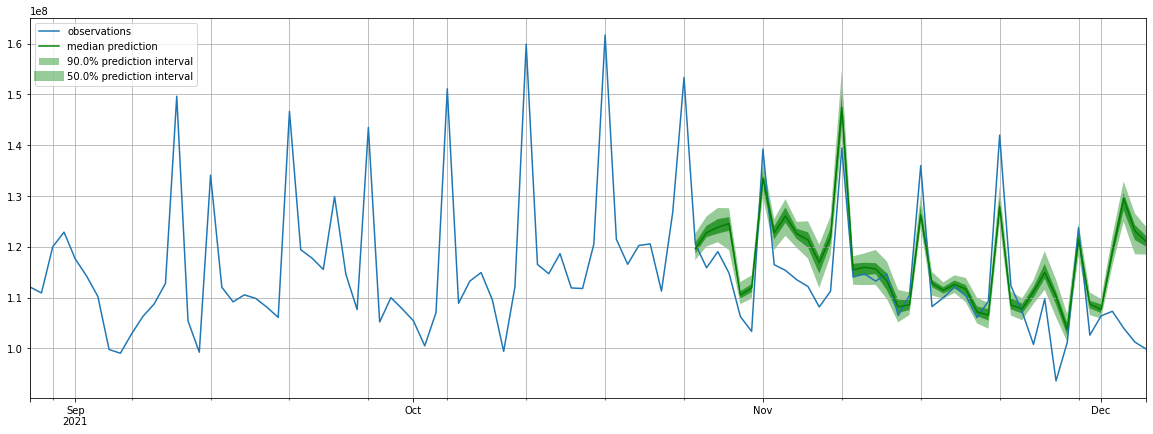

In [20]:
for i in range(1):
    plot_prob_forecasts(tss[i], forecasts[i], plot_length=100, prediction_intervals = (50.0, 90.0))

In [21]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq



In [22]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 81866535309212.1,
    "abs_error": 278216896.0,
    "abs_target_sum": 4612718592.0,
    "abs_target_mean": 112505331.51219513,
    "seasonal_error": 5116456.724081185,
    "MASE": 1.3262650926531787,
    "MAPE": 0.06177473068237305,
    "sMAPE": 0.05886333163191632,
    "MSIS": 30.354897231476347,
    "QuantileLoss[0.1]": 312873904.0,
    "Coverage[0.1]": 0.5609756097560976,
    "QuantileLoss[0.5]": 278216880.0,
    "Coverage[0.5]": 0.7804878048780488,
    "QuantileLoss[0.9]": 105332968.0,
    "Coverage[0.9]": 0.8536585365853658,
    "RMSE": 9048012.782330278,
    "NRMSE": 0.08042296894480516,
    "ND": 0.06031516782370408,
    "wQuantileLoss[0.1]": 0.06782852622803139,
    "wQuantileLoss[0.5]": 0.06031516435503378,
    "wQuantileLoss[0.9]": 0.022835333632249464,
    "mean_absolute_QuantileLoss": 232141250.66666666,
    "mean_wQuantileLoss": 0.05032634140510487,
    "MAE_Coverage": 0.2626016260162602,
    "OWA": NaN
}


In [23]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,169843.0,8.186654e+13,278216896.0,4.612719e+09,1.125053e+08,5.116457e+06,1.326265,0.061775,0.058863,30.354897,312873904.0,0.560976,278216880.0,0.780488,105332968.0,0.853659


In [24]:
fc_val = forecasts[0].samples
fc_mean = fc_val.mean(axis=0)
display_df = nbcu_comp_test.copy()
display_df['p50'] = fc_mean
display_df['deviation'] = display_df[['inventory', 'p50']].apply(lambda x: abs(x.p50-x.inventory)/x.inventory * 100, axis=1)

<AxesSubplot:xlabel='1'>

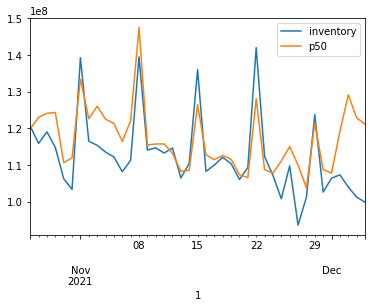

In [25]:
display_df[['inventory', 'p50']].plot()

In [26]:
display_df['deviation'].mean()

6.149708611864606

## No Event Training

In [ ]:
def network_dataset(data_df:pd, event, freq='D', valid_length=0, test_length=0):
    # data_df: base dataset from by network inventories
    data_df = data_df.pivot_table(index=data_df.index, columns=['site_id']).fillna(0)
    
    #remove this line after testing
    #data_df = data_df[1:2]
    
    num_series, num_steps = data_df.shape
    print(num_series, num_steps, data_df.columns[0][1]) 
    
    train_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r[:-(valid_length+test_length)],
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event[:-(valid_length+test_length)] if event else None,
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )
    valid_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r[:-test_length],
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event[:-test_length] if event else None,
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )    
    test_ds = ListDataset(
        [
            {
                FieldName.ITEM_ID: i,
                FieldName.TARGET: r,
                FieldName.START: data_df.columns[0][1],
                FieldName.FEAT_DYNAMIC_REAL: event if event else None,
                FieldName.FEAT_STATIC_CAT: None
            }
            for i, r in data_df.iterrows()
        ],
        freq=freq
    )
    
    return train_ds, valid_ds, test_ds #target, feat_dynamic_real, feat_static_cat

In [ ]:
train_ds2, valid_ds2, test_ds2 = network_dataset(
    merged_df, 
    False,
    freq=ds_meta['freq'],
    valid_length=0, #ds_meta['validation_length'],
    test_length=ds_meta['prediction_length']
)

In [ ]:
deepAR_estimator = DeepAREstimator(
    prediction_length=ds_meta['prediction_length'],
    context_length=3688,
    freq=ds_meta['freq'],
    num_layers=5,
    num_cells=90,
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
#    cardinality=stat_cat_cardinalities,
    dropout_rate=0.1,
    cell_type='lstm',
    trainer=Trainer(   
#        ctx=gpu(0),
        learning_rate=1e-3, patience=50,
        epochs=100,
        num_batches_per_epoch=90,
#        batch_size=64
    )
)

In [ ]:
deepAR_predictor = deepAR_estimator.train(training_data=train_ds2)

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds2,  # test dataset
    predictor=deepAR_predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
for i in range(1):
    plot_prob_forecasts(tss[i], forecasts[i], plot_length=100, prediction_intervals = (50.0, 90.0))

In [ ]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

In [ ]:
print(json.dumps(agg_metrics, indent=4))

In [ ]:
item_metrics

In [ ]:
fc_val = forecasts[0].samples
fc_mean = fc_val.mean(axis=0)
display_df = nbcu_comp_test.copy()
display_df['p50'] = fc_mean
display_df['deviation'] = display_df[['inventory', 'p50']].apply(lambda x: abs(x.p50-x.inventory)/x.inventory * 100, axis=1)
display_df['deviation'].mean()

In [ ]:
display_df[['inventory', 'p50']].plot()